In [1]:
################### LER A IMAGEM DE LUZ NOTURNA ####################
from osgeo import gdal, ogr, osr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os.path
import os
import scipy
from sklearn import cluster
'''
Utiliza dos filtros disponíveis no scipy.ndimage
fontes:
geral -> https://docs.scipy.org/doc/scipy/tutorial/index.html
filtros -> https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.minimum_filter.html#scipy.ndimage.minimum_filter
'''
from scipy import ndimage

########### ABRIR ARQUIVO RASTER ###############################################
######## É PRECISO QUE A PROJEÇÃO ESTEJA EM UTM ###################
img = 'D:/INPE_DISCIPLINAS/Dissertacao/raster/luz_noturna/nighttime_STR_2013_31981.tif'

ds = gdal.Open(img)
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

band = ds.GetRasterBand(1)
array = band.ReadAsArray()

In [68]:
def feng_kmeans( array, arraySize = (3,3), clusters = 3 ):
    '''
    Using DMSP/OLS nighttime light data and K–means method to identify urban–rural fringe of megacities. FENG, Z.; PENG, F.; WU, J. (2020)
    
    Nighttime light fluctuation:
    DNfi = DNmax - DNmin
  
    DNmax = valor maximo de DN numa vizinhança
    DNmin = valor minimo de DN numa vizinhança    '''
    
    img_min = ndimage.minimum_filter(array, size=(3,3) )
    img_max = ndimage.maximum_filter(array, size=(3,3) )
    img_feng = img_max - img_min
    
    img_feng = np.nan_to_num(img_feng)
    
    stacked = (array + img_feng)
    
    stacked = np.nan_to_num(stacked)
    
    X = img_feng.reshape((-1,1))
    
    k_means = cluster.KMeans(n_clusters=3)
    k_means.fit(X)

    X_cluster = k_means.labels_
    X_cluster = X_cluster.reshape(array.shape)
    
    
    plt.figure(figsize=(15, 8))
    
    plt.subplot(221)
    plt.title("Filtro Minimo")
    plt.imshow(img_min, cmap='gray')

    plt.subplot(222)
    plt.title("Filtro Máximo")
    plt.imshow(img_max, cmap='gray')

    plt.subplot(223)
    plt.title("DNfi")
    plt.imshow(img_feng, cmap='gray')
    
    plt.subplot(224)
    plt.title("Cluster")
    plt.imshow(X_cluster)
    
    return img_feng, X_cluster
    

(array([[0.        , 0.        , 0.        , ..., 0.13529456, 0.13529456,
         0.04835662],
        [0.        , 0.        , 0.        , ..., 0.13529456, 0.13529456,
         0.09692809],
        [0.01814184, 0.04330342, 0.02994746, ..., 0.0930962 , 0.08693794,
         0.04857147],
        ...,
        [0.01587071, 0.01587071, 0.01589972, ..., 0.02417313, 0.0810294 ,
         0.06859655],
        [0.06378829, 0.06378829, 0.06573144, ..., 0.01729748, 0.07527354,
         0.06859655],
        [0.05965757, 0.06183117, 0.06573144, ..., 0.0067137 , 0.07527354,
         0.06859655]], dtype=float32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

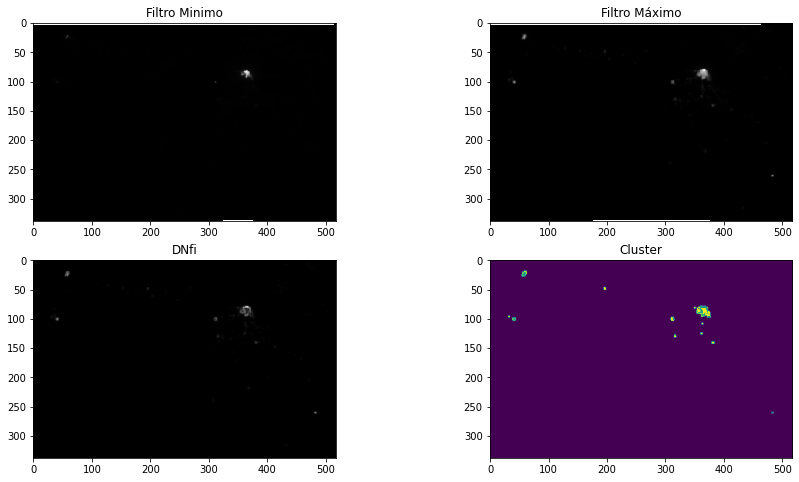

In [69]:
feng_kmeans(array, arraySize = (3,3), clusters = 3)

In [66]:
##################  EXPORTANDO IMAGENS. AJUSTAR OS PARAMETROS "imagens", "nomes", 'banda'

imagens = [img_feng, X_cluster]
nomes = ['img_feng2013.tif', 'clusterFeng2013.tif']
b = 1

for n in nomes:
    
    banda = 'D:/INPE_DISCIPLINAS/Dissertacao/raster/FENG/'+n  # local do arquivo limiarizado.tif     #

    if os.path.exists(banda):
        os.remove(banda)
    
    driver = gdal.GetDriverByName('GTiff')
    driver.Register()

    outds = driver.Create(banda, xsize=imagens[b].shape[1],
                     ysize = imagens[b].shape[0],
                     bands = 1,
                     eType = gdal.GDT_Float32)

    outds.SetGeoTransform(gt)
    outds.SetProjection(proj)
    outband = outds.GetRasterBand(1)
    outband.WriteArray(imagens[b])
    outband.SetNoDataValue(np.nan)
    outband.FlushCache()

    outband = None
    outds = None